# Sentiment analysis of movie reviews

Links
* [Keras datasets](https://keras.io/datasets/)
* [Prepare data for text processing](https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/)
* [Keras embedding and tokenizer](http://www.orbifold.net/default/2017/01/10/embedding-and-tokenizer-in-keras/)
* [Pre-trained word embeddings in Keras](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)

In [20]:
import numpy as np
import keras
from keras.datasets import imdb
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

## Load and summarize data

Load the movie review data set

In [21]:
(X_train, y_train), (X_test, y_test) = imdb.load_data()
print('There are {:,} training and {:,} test examples'.format(
    X_train.shape[0], X_test.shape[0]))

There are 25,000 training and 25,000 test examples


In [22]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

Get ratings for both training and test data

In [23]:
unique, counts = np.unique(y, return_counts=True)
ratings = dict(zip(unique, counts))
print('There are {r[0]:,} "0" ratings, and {r[1]:,} "1" ratings'.format(
    r=ratings))

There are 25,000 "0" ratings, and 25,000 "1" ratings


Get word to integer dictionary and create the inverse mapping

In [24]:
imdb_word_int = imdb.get_word_index()
imdb_int_word = {int_val:word for word, int_val in imdb_word_int.items()}

Display the first review using only words. The punctuation has been removed

In [25]:
review_idx = 0
review_int = X_train[review_idx]
review_rating = y_train[review_idx]
review = ' '.join([imdb_int_word[int_val] for int_val in review_int])
print('rating {}'.format(review_rating))
review

rating 1


"the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room titillate it so heart shows to years of every never going villaronga help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but pratfalls to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other tricky in of seen over landed for anyone of gilmore's br show's to whether from than out themselves history he name half some br of 'n odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but wh

Display the unique number of words in the data set

In [26]:
len(np.unique(np.hstack(X)))

88585

Calculate and display the typical length of reviews (in words)

Text(0.5,1,'histogram of review lengths')

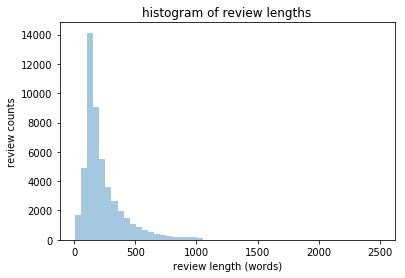

In [28]:
review_len = [len(review) for review in X]
g = sns.distplot(review_len, kde=False, axlabel='review length (words)')
g.set_ylabel('review counts')
g.set_title('histogram of review lengths')